# LQR control of learned dynamics for pendulum

## Pendulum simulation with a control input $u$

$$\frac{1}{2}m L^2 \ddot{\theta} + mg sin(\theta) = u$$ <br> 

With $u$ being the torque applied on the pendulum rotation center. Now, the goal is to simulate this system for given inputs $u$ and store the values for both
$u$ and the states. But first, transform to state-space.

In [189]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt

def Pendulum(theta, u, params):
    
    g = 9.81
    m = params["mass"]
    l = params["length"]
    x1 = theta[0]
    x2 = theta[1]
    dx1dt = x2
    dx2dt = 2/(m*l**2)*(u - m*g*np.sin(x1))
    dxdt = np.array([dx1dt, dx2dt])
     
    return dxdt

Now simulate and plot the pendulum trajectory using a pre-defined torque input $u$ and integrate using a *Runge-Kutta 4* integrator to retrieve the states, i.e. $x_1 = \theta$, 
$x_2 = \dot{\theta}$ and $x_3 = \ddot{\theta}$.

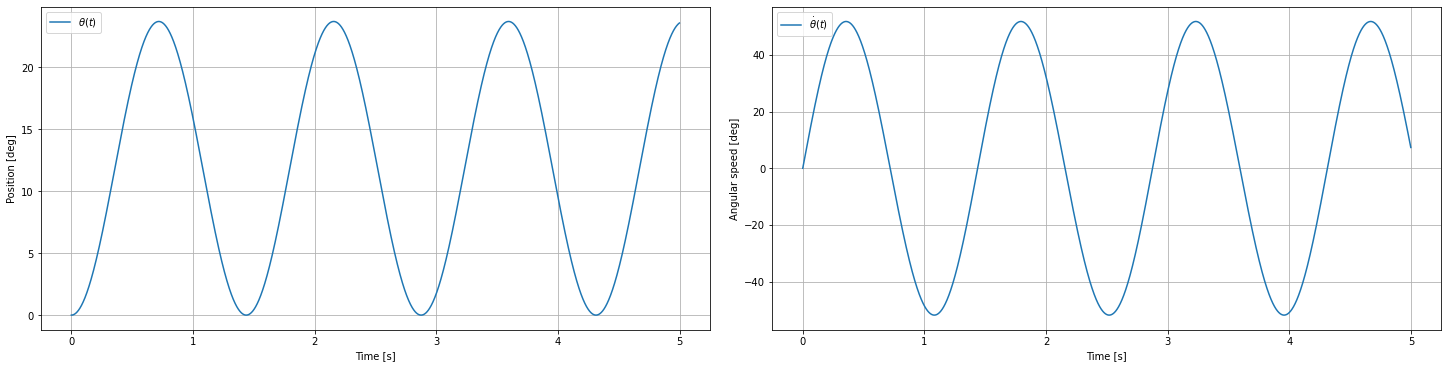

In [229]:
import Utils.Functions 
reload(Utils.Functions)
from Utils.Functions import *

# Parameters 
X0 = np.array([deg2rad(0), 0]) # Initial condition (horizontal)
t = np.arange(0.0,5,0.001) # Time horizon
torque = 2*np.ones([t.shape[0]]) # Control input [Nm]
params = {"mass":1, "length":1}

# Simulation
f = lambda x, t, u : Pendulum(x, u, params) # Pass parameters to the lambda function
X = RK4(f, X0, torque, t)
torque = torque[:,np.newaxis] # For later on

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(t, 180/np.pi*X[0,:], label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, 180/np.pi*X[1,:], label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

## Linear dynamics learning

Now, we can find an approximate linear representation of the non-linear pendulum dynamics using the Least-Square algorithm. We try to represent the dynamics as follows : <br><br>
$$\begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k)$$ <br><br>

The matrices $A$ and $B$ can be put together, yielding a linear regression problem. Also, many observations can be used. However, in order to construct a least square problem, the right-hand side can be inverted as follows : <br><br>

$$\begin{pmatrix} x_1(1) & x_2(1) \\ \vdots & \vdots \\ x_1(T) & x_2(T) \end{pmatrix} = \begin{pmatrix} x_1(0) & x_2(0) & u(0) \\ \vdots & \vdots & \vdots \\ x_1(T-1) & x_2(T-1) & u(T-1) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix}$$ <br><br>

Now, let's write the least square problem, $\theta$ being the *parameter* vector, $\Phi$ the *observations* vector and $Y$ the *measurement* vector : <br><br>

$$\bar{A} \bar{X} = \bar{Y} \Longleftrightarrow \bar{X}^T \bar{A}^T = \bar{Y}^T \Longleftrightarrow \Phi \theta = Y$$

$$ \hat{\theta} = (\Phi^T \Phi)^{-1} \Phi^T Y $$

In [230]:
from numpy.linalg import inv

# Create delayed state evolution matrices
Y = (X[:,1:X.shape[1]]).T
Phi = np.concatenate((X[:,0:X.shape[1]-1].T, torque[0:torque.shape[0]-1]), axis=1)

# Compute the estimated parameters
theta_hat = (inv(Phi.T@Phi)@Phi.T@Y).T
print(theta_hat)

[[ 9.99990449e-01  9.99995358e-04  9.91148481e-07]
 [-1.91017712e-02  9.99987533e-01  1.98229027e-03]]


Now, let's compare these linear dynamics with the original, non-linear dynamics.

In [194]:
def linPendulum(theta, theta_hat, u, params):
    
    g = 9.81
    A = theta_hat[:,0:2]
    B = theta_hat[:,2:3]
    m = params["mass"]
    l = params["length"]
    x1 = theta[0]
    x2 = theta[1]
    dx1dt = A[0,0]*x1 + A[0,1]*x2 + B[0]*u
    dx2dt = A[1,0]*x1 + A[1,1]*x2 + B[1]*u
    dxdt = np.array([dx1dt, dx2dt])[:,0]
     
    return dxdt

(2, 2) (2,) [[ 0.99999045  0.001     ]
 [-0.01910177  0.99998753]] [9.91148481e-07 1.98229027e-03]


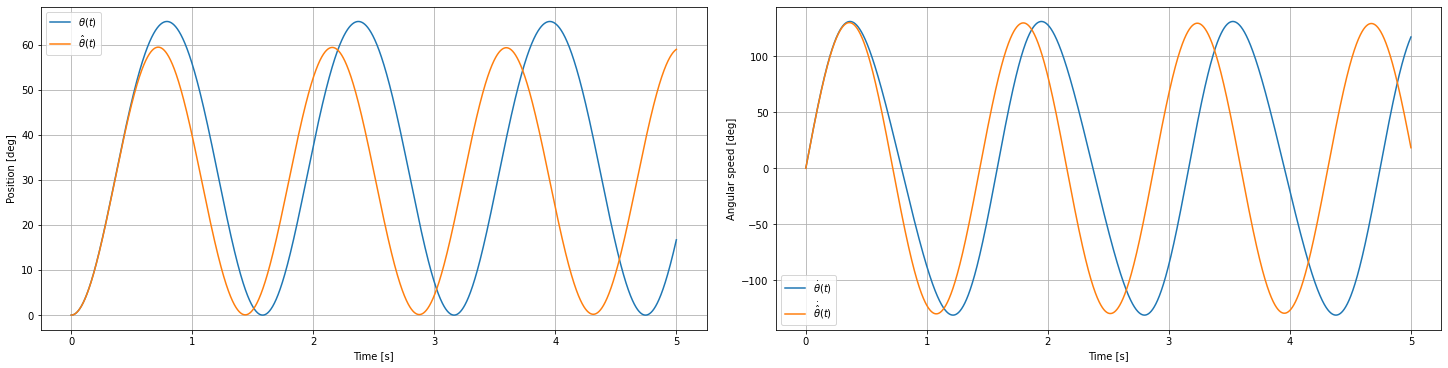

In [234]:
# Linear & non-linear simulations
import Utils.Functions 
reload(Utils.Functions)
from Utils.Functions import *

# Parameters 
X0 = np.array([deg2rad(0), 0]) # Initial condition (horizontal)
t = np.arange(0.0,5,0.001) # Time horizon
torque = 5*np.ones([t.shape[0]]) # Control input [Nm]
params = {"mass":1, "length":1}
A = theta_hat[:,0:2]
B = theta_hat[:,2:3][:,0]
print(A.shape, B.shape, A, B)

# Simulation
f_hat = lambda x, t, u : linPendulum(x, theta_hat, u, params) # Pass parameters to the lambda function
X = RK4(f, X0, torque, t)
X_hat = discreteSimulation(A, B, X0, torque, t)

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(t, 180/np.pi*X[0,:], label=r"$\theta (t)$")
ax[0].plot(t, 180/np.pi*X_hat[0,:], label=r"$\hat{\theta} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, 180/np.pi*X[1,:], label=r"$\dot{\theta} (t)$")
ax[1].plot(t, 180/np.pi*X_hat[1,:], label=r"$\dot{\hat{\theta}} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

Let's compare this with the small-angle approximation of the pendulum dynamics : <br><br>
$$\frac{1}{2}m L^2 \ddot{\theta} + mg \theta = u$$ <br><br>
And then simulate it along its non-linear counterpart.

In [199]:
def smallAnglePendulum(theta, u, params):
    
    g = 9.81
    m = params["mass"]
    l = params["length"]
    x1 = theta[0]
    x2 = theta[1]
    dx1dt = x2
    dx2dt = 2/(m*l**2)*(u - m*g*x1)
    dxdt = np.array([dx1dt, dx2dt])
     
    return dxdt

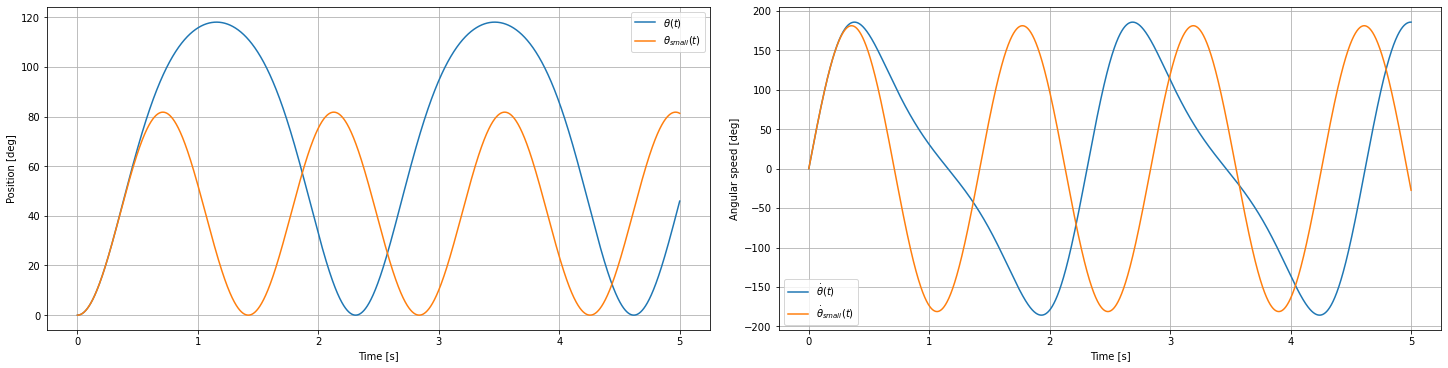

In [207]:
import Utils.Functions 
reload(Utils.Functions)
from Utils.Functions import *

# Parameters 
X0 = np.array([deg2rad(0), 0]) # Initial condition (horizontal)
t = np.arange(0.0,5,0.001) # Time horizon
torque = 7*np.ones([t.shape[0]]) # Control input [Nm]
params = {"mass":1, "length":1}

# Simulation
f_small = lambda x, t, u : smallAnglePendulum(x, u, params) # Pass parameters to the lambda function
X = RK4(f, X0, torque, t)
X_small = RK4(f_small, X0, torque, t)

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(t, 180/np.pi*X[0,:], label=r"$\theta (t)$")
ax[0].plot(t, 180/np.pi*X_small[0,:], label=r"$\theta_{small} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, 180/np.pi*X[1,:], label=r"$\dot{\theta} (t)$")
ax[1].plot(t, 180/np.pi*X_small[1,:], label=r"$\dot{\theta}_{small} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()